# Transitioning to autonomous driving: <br>Mixed vehicle autonomy levels on freeways
### Notebook to analyse simulation warm-up time.

Jesse Poland<br>
TU Delft<br>
Date: 02-10-2024<br>

### 0. Python packages and loading data files

First, Python packages are imported to provide specific functionalities within the notebook. Then, the file paths are set to retrieve stored simulation data for all experiment runs and seeds. The simulation data is loaded into Pandas DataFrames, making the data ready for analysis.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from IPython.display import display
import zipfile

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_rows', None)

In [2]:
# simulation output folder
# experiment_name = 'explore_demand_test'
experiment_name = 'B0_sensitivity_run_2'

# load Java simulation data
experiment_folder = fr'F:\jesse_sim_results\{experiment_name}'
# experiment_folder = fr'..\data\{experiment_name}'

# available files
input_values = 'inputValues.csv'
intermediate_output = 'intermediateOutputData.csv'
single_output = 'singleOutputData.csv'
sequence_output = 'sequenceOutputData.csv'
lane_change_output = 'laneChangeOutputData.csv'
collision_output = 'collisionOutputData.csv'

In [3]:
# function to get a list of all file/folder names within a folder
def get_file_names(path):
    return os.listdir(path)

# load available seed folders
seed_folders = get_file_names(experiment_folder)

In [4]:
# function to retrieve any data within the project folder as dataframe
def load_dataframe(columns_of_interest, folder, file, input_file=None):
    # create empty DataFrame
    df = pd.DataFrame()
    
    # loop through all seed folders from this experiment
    for seed_name in get_file_names(folder):
        # get all runs within this experiment
        run_folders = get_file_names(os.path.join(folder, seed_name))

        # go through all runs
        for run_folder in run_folders:
            run_number = int(run_folder.split('_')[1])
            data_folder = os.path.join(folder, seed_name, run_folder)

            # open zip file (remove .csv form file name)
            try:
                with zipfile.ZipFile(os.path.join(data_folder, fr'{file[:-4]}.zip'), 'r') as zip_ref:
                    # read sequence csv
                    with zip_ref.open(file) as data_file:
                        df_run = pd.read_csv(data_file)
                        df_interest = df_run[columns_of_interest].copy()
                        df_interest['run'] = run_number
                # add input values to the dataframe if the input file is specified
                if input_file is not None:
                    # open input zip file
                    with zipfile.ZipFile(os.path.join(data_folder, fr'{input_file[:-4]}.zip'), 'r') as zip_ref:
                        # read input csv
                        with zip_ref.open(input_file) as input_data_file:
                            df_input = pd.read_csv(input_data_file)
                    # broadcast input data to all rows in df_interest
                    for col in df_input.columns:
                        df_interest[col] = df_input[col].iloc[0]
    
                # add this data to the main DataFrame
                df = pd.concat([df, df_interest])
            except:
                print(f'An error occured when trying to read data from: {data_folder}. This folder may contain a BadZipFile or is empty.')
    
    # return resulting DataFrame
    df.reset_index(drop=True, inplace=True)
    return df
    

In [5]:
# get GTU data
variables = ['time', 'gtu_id', 'gtu_type', 'acceleration', 'speed']
df_gtu = load_dataframe(variables, experiment_folder, sequence_output, input_values)
# only include sensitivity analysis parameter from input data
df_gtu = df_gtu[variables + ['seed', 'run', 'sensitivity_analysis_value']]
# rename column of the sensitivity analysis parameter
df_gtu.rename(columns = {'sensitivity_analysis_value':'b0'}, inplace = True)

In [6]:
# split dataframe for automation levels
df_level0 = df_gtu[df_gtu['gtu_type'] == 'LEVEL0']
df_level1 = df_gtu[df_gtu['gtu_type'] == 'LEVEL1']
df_level2 = df_gtu[df_gtu['gtu_type'] == 'LEVEL2']
df_level3 = df_gtu[df_gtu['gtu_type'] == 'LEVEL3']

In [31]:
def sensitivity_analysis_line_plot_mean(df, sens_param, dependent_param, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(12, 4))
        
    # remove NaN and inf values in time headway since not all data points have a leading vehicle
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(subset=[dependent_param])
    
    # group by the sensitivity parameter and calculate mean, min, and max of the dependent parameter
    stats_by_sens_param = df.groupby(sens_param)[dependent_param].agg(['mean', 'min', 'max']).reset_index()
    stats_by_sens_param.rename(columns={'mean': f'mean_{dependent_param}', 'min': f'min_{dependent_param}', 'max': f'max_{dependent_param}'}, inplace=True)
    
    # sort values by the sensitivity parameter to ensure correct plotting order
    stats_by_sens_param = stats_by_sens_param.sort_values(by=sens_param)
    
    # plot the mean, min, and max values against the sensitivity analysis parameter
    ax.plot(stats_by_sens_param[sens_param], stats_by_sens_param[f'mean_{dependent_param}'], marker='o', color='blue', label='Mean')
    # ax.fill_between(stats_by_sens_param[sens_param], 
    #                  stats_by_sens_param[f'min_{dependent_param}'], 
    #                  stats_by_sens_param[f'max_{dependent_param}'], 
    #                  color='lightblue', alpha=0.3, label='Range (Min to Max)')

    # display data point values
    # for i, row in stats_by_sens_param.iterrows():
    #     ax.text(row[sens_param], row[f'mean_{dependent_param}'], f'({row[sens_param]:.2f}, {row[f"mean_{dependent_param}"]:.2f})', fontsize=9, ha='right')
    
    # labels and title
    ax.set_xlabel(f'{sens_param.capitalize().replace("_", "")}')
    ax.set_ylabel(f'{dependent_param.capitalize().replace("_", " ")} [s]')
    ax.set_title(f'Influence of {sens_param.capitalize().replace("_", "")} on {dependent_param.replace("_", " ")}')
    ax.grid(True)
    ax.legend()

In [8]:
def plot_for_all_levels(dataframe_list, sensitivity_param, dependent_param):
    # create plots for all sections
    n_columns = 2
    n_rows = (len(dataframe_list) + n_columns - 1) // n_columns
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(16, n_rows * 5))
    axes = axes.flatten()

    # plot all dataframes
    for i, df in enumerate(dataframe_list):
        sensitivity_analysis_line_plot_mean(df, sensitivity_param, dependent_param, ax=axes[i])

    # display all plots
    plt.show()

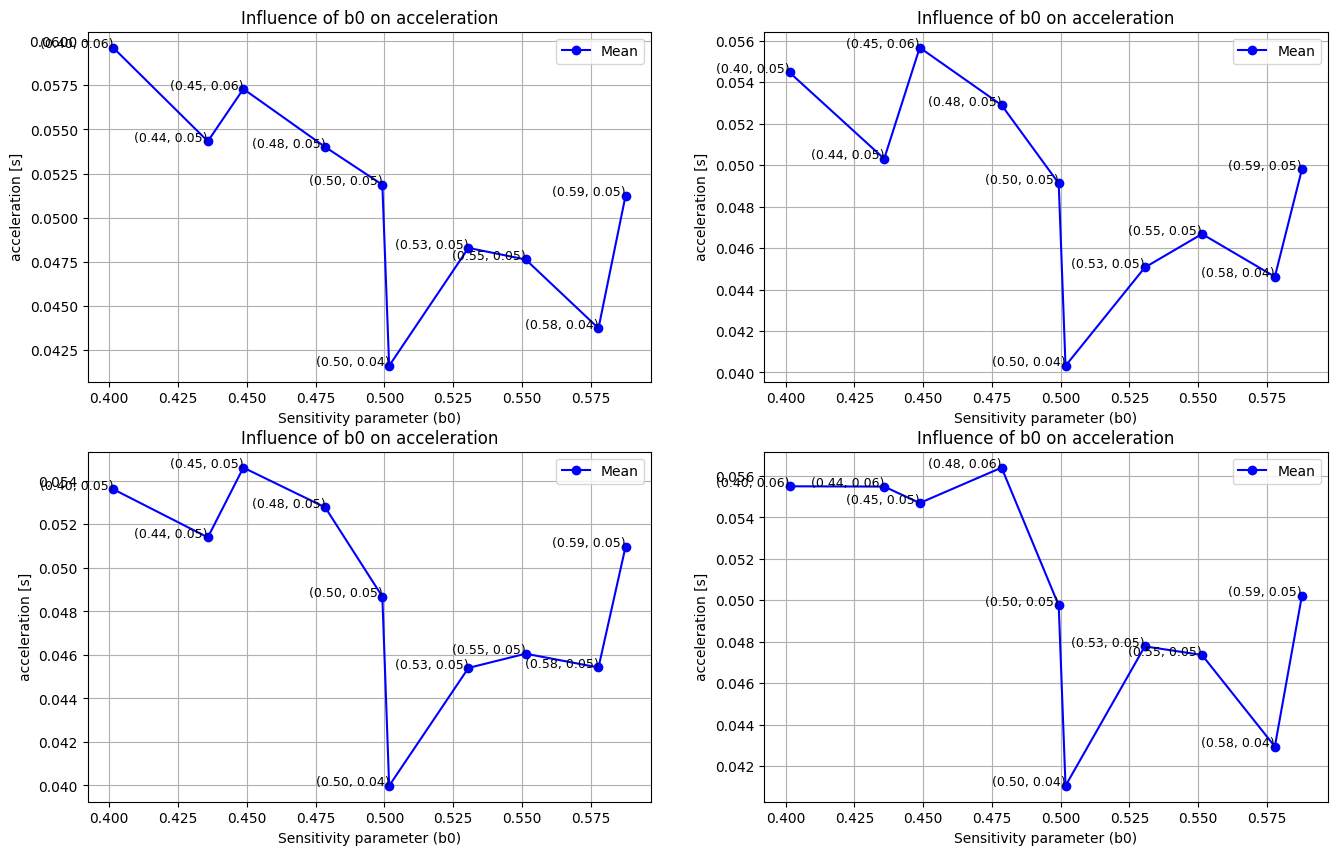

In [9]:
# show influence of t_max on headway_time
plot_for_all_levels([df_level0, df_level1, df_level2, df_level3], 'b0', 'acceleration')

In [10]:
def calculate_jerk(df):
    # sort by time within each group to ensure jerk is calculated correctly
    df = df.sort_values(by=['gtu_id', 'seed', 'run', 'time'])
    
    # define the time step in seconds
    time_step = 0.5
    
    # calculate jerk within each (gtu_id, seed, run) group
    df['jerk'] = (df.groupby(['gtu_id', 'seed', 'run'])['acceleration'].diff() / time_step )

    # return dataframe with jerk column
    return df


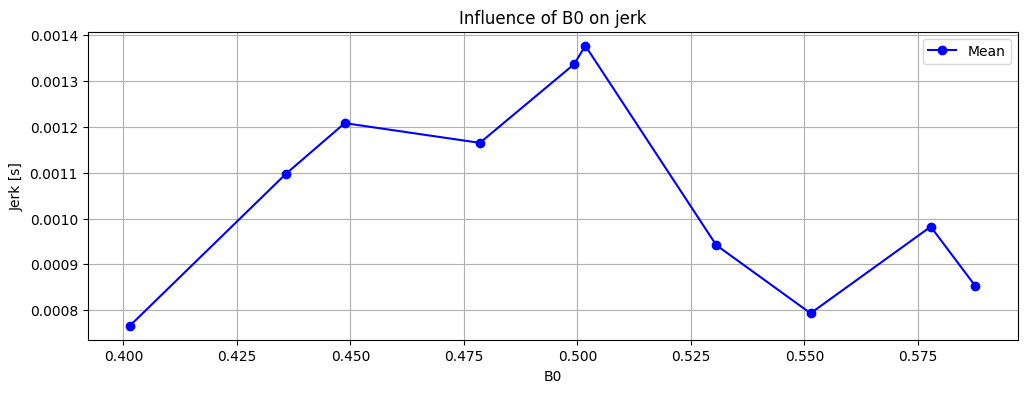

In [32]:
sensitivity_analysis_line_plot_mean(calculate_jerk(df_gtu), 'b0', 'jerk')

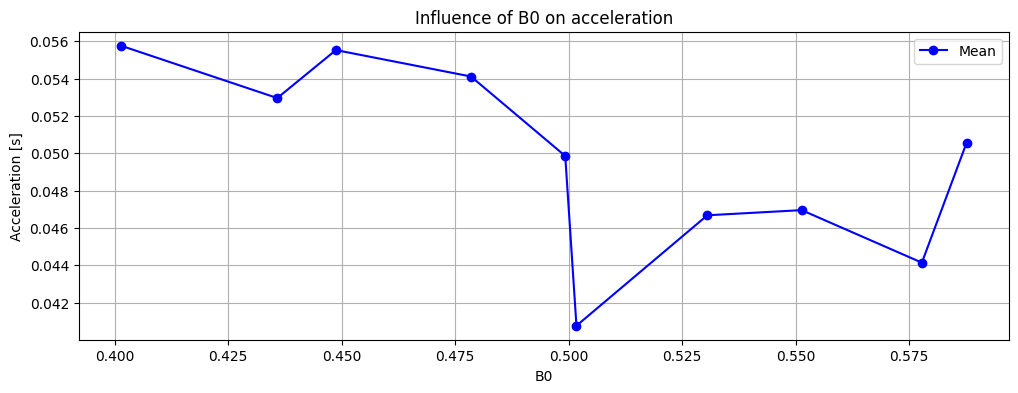

In [33]:
sensitivity_analysis_line_plot_mean(df_gtu, 'b0', 'acceleration')

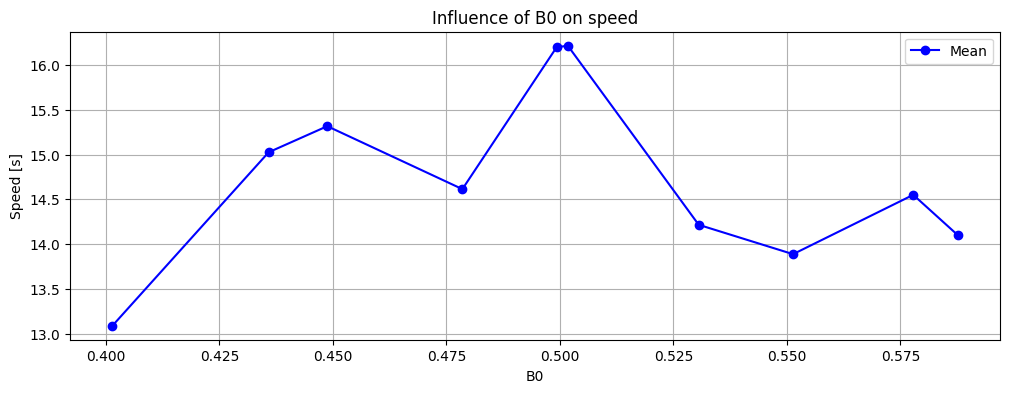

In [34]:
sensitivity_analysis_line_plot_mean(df_gtu, 'b0', 'speed')

In [13]:
# add time column
def add_time_column(df, sample_interval):
    df['time'] = df.groupby(['seed', 'run']).cumcount() * sample_interval
    return df

# filter columns
def filter_columns(df, selected_variables):
    columns_to_include = [col for col in df.columns if col in selected_variables]
    df = df[columns_to_include]
    return df

# convert data
def convert_fd_data(df):
    df_converted = df.copy()
    for col in df_converted.columns.tolist():
        if 'flow' in col:
            df_converted[col] = df_converted[col].astype(float) * 3600
        if 'density' in col:
            df_converted[col] = df_converted[col].astype(float) * 1000
        if 'speed' in col:
            df_converted[col] = df_converted[col].astype(float) * 3.6
    return df_converted

def show_fd_scatter_plot_sections(df, sens_param, sens_param_values, section):
    # sort values
    sorted_values = sorted(sens_param_values)
    # create plots for all sections
    n_columns = 2
    n_rows = (len(sorted_values) + n_columns - 1) // n_columns
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(12, n_rows * 3))
    axes = axes.flatten()
    
    # print each seed seperately
    for i, value in enumerate(sorted_values):
        # get copy of df
        df_temp = df.copy()
        # only get dataframe with this value
        df_temp = df_temp[df_temp[sens_param] == value]
        # plot figure
        scatter = axes[i].scatter(df_temp[f'{section}_density'], df_temp[f'{section}_flow'], c=df_temp['time'], cmap='viridis')
        axes[i].set_xlabel('Density [veh/km]')
        axes[i].set_ylabel('Flow [veh/h]')
        axes[i].set_title(f'Fundamental diagram section {section} for {sens_param} value: {value:.2f}')

        # set color bar
        fig.colorbar(scatter, ax=axes[i], label='Time [s]')
    
    # hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # show plots
    plt.tight_layout()
    plt.show()

In [14]:
# select merging lanes and required FD variables
variables = ['AB.LEFT_density', 'AB.LEFT_flow', 'AB.LEFT_speed',
             'AB.RIGHT_density', 'AB.RIGHT_flow', 'AB.RIGHT_speed',
             'BC.LEFT_density', 'BC.LEFT_flow', 'BC.LEFT_speed',
             'BC.RIGHT_density', 'BC.RIGHT_flow', 'BC.RIGHT_speed',
             'BC.ONRAMP_density', 'BC.ONRAMP_flow', 'BC.ONRAMP_speed',
             'CD.LEFT_density', 'CD.LEFT_flow', 'CD.LEFT_speed',
             'CD.RIGHT_density', 'CD.RIGHT_flow', 'CD.RIGHT_speed',
             'E2B.ONRAMP_density', 'E2B.ONRAMP_flow', 'E2B.ONRAMP_speed'
            ]
# get intermediate FD data
df_fd = load_dataframe(variables, experiment_folder, intermediate_output, input_values)
# remove empty rows (these exist because other variables are also stored in the intermediate CSV)
# flow variable is always 0, so NaN value indicates that no data was recorded at all
df_fd = df_fd.dropna(subset=['BC.RIGHT_flow'])
# add time column, each FD calculation represents 30 sec
df_fd = add_time_column(df_fd, 30)
# select columns of interest
# variables_of_interest = ['time', 'seed', 'run', 'main_demand'] + variables
variables_of_interest = ['time', 'seed', 'run', 'sensitivity_analysis_value'] + variables
df_fd = filter_columns(df_fd, variables_of_interest)
# rename column of the sensitivity analysis parameter
df_fd.rename(columns = {'sensitivity_analysis_value':'b0'}, inplace = True)

In [15]:
# combine road areas
df_fd_combined = pd.DataFrame()
# get run info
df_fd_combined['time'] = df_fd['time']
df_fd_combined['b0'] = df_fd['b0']
# df_fd_combined['main_demand'] = df_fd['main_demand']
df_fd_combined['seed'] = df_fd['seed']
df_fd_combined['run'] = df_fd['run']
# create AB section (main lanes pre-merging)
df_fd_combined['AB_flow'] = df_fd['AB.LEFT_flow'] + df_fd['AB.RIGHT_flow']
df_fd_combined['AB_density'] = (df_fd['AB.LEFT_density'] + df_fd['AB.RIGHT_density']) / 2
df_fd_combined['AB_speed'] = (df_fd['AB.LEFT_speed'] + df_fd['AB.RIGHT_speed']) / 2
# create BC section (main lanes + merging lane)
df_fd_combined['BC_flow'] = df_fd['BC.LEFT_flow'] + df_fd['BC.RIGHT_flow'] + df_fd['BC.ONRAMP_flow']
df_fd_combined['BC_density'] = (df_fd['BC.LEFT_density'] + df_fd['BC.RIGHT_density'] + df_fd['BC.ONRAMP_density']) / 3
df_fd_combined['BC_speed'] = (df_fd['BC.LEFT_speed'] + df_fd['BC.RIGHT_speed'] + df_fd['BC.ONRAMP_speed']) / 3
# create CD section (main lanes post-merging)
df_fd_combined['CD_flow'] = df_fd['CD.LEFT_flow'] + df_fd['CD.RIGHT_flow']
df_fd_combined['CD_density'] = (df_fd['CD.LEFT_density'] + df_fd['CD.RIGHT_density']) / 2
df_fd_combined['CD_speed'] = (df_fd['CD.LEFT_speed'] + df_fd['CD.RIGHT_speed']) / 2
# also include onramp lane
df_fd_combined['E2B.ONRAMP_flow'] = df_fd['E2B.ONRAMP_flow']
df_fd_combined['E2B.ONRAMP_density'] = df_fd['E2B.ONRAMP_density']
df_fd_combined['E2B.ONRAMP_speed'] = df_fd['E2B.ONRAMP_speed']
# convert FD values
df_new_fd = convert_fd_data(df_fd_combined)

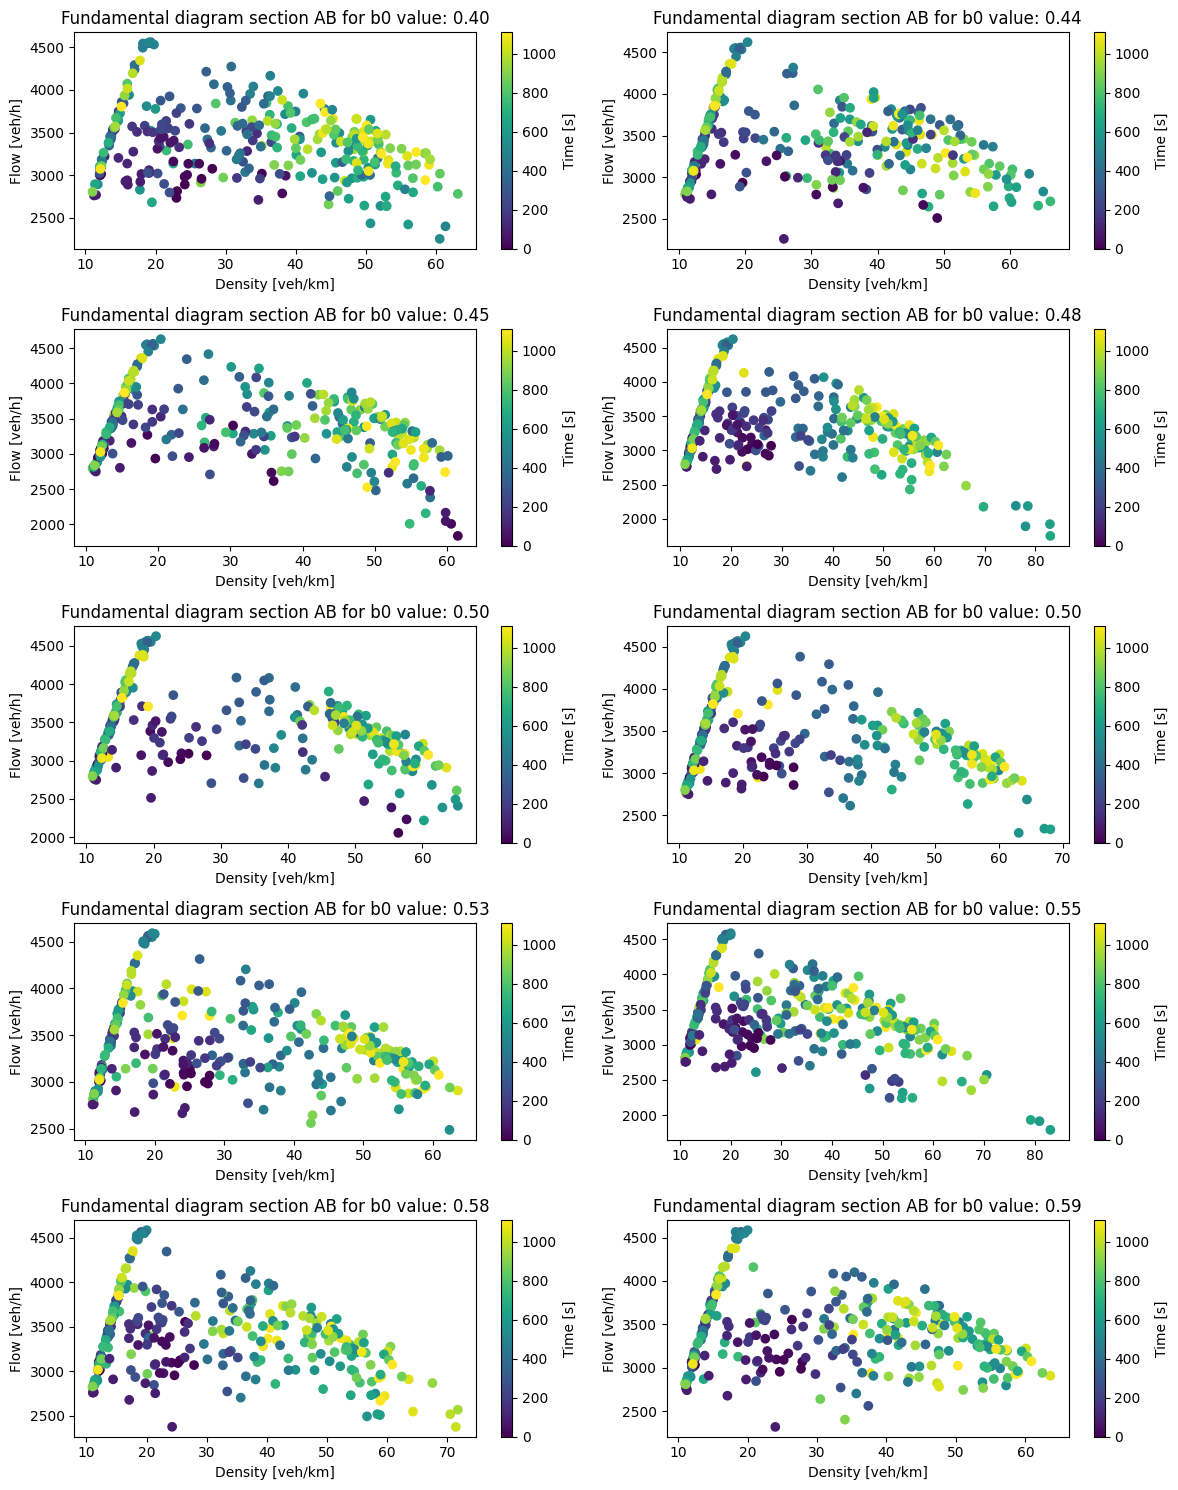

In [16]:
show_fd_scatter_plot_sections(df_new_fd, 'b0', df_new_fd['b0'].unique().tolist(), 'AB')

### Conclusion
